# Tensorflow Working Session - Day 1

In [81]:
import numpy as np
import tensorflow as tf 
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


In [1]:
# Let's create a function to make the notebook's 
# output stable across runs. This will reset the
# nodes of the graph. 
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

## What Does Tensorflow Do?

<img src='images/what_is_tensorflow.png'>


### The Tensorflow Session

Tensorflow runs using computation graphs. Let's look at an example of such a computation graph for the equation below: 

$f(x,y) = x^{2}y + y + 2$.

The computation graph defined in tensorflow is:

<img src='images/mlst_0901.png'>

where the equations are the *edges* and the operations are the *nodes*. 

`tf.Session()` represents a connection between the client program, provides access to devices in local/remote machines, caches info about the computation graph called`tf.Graph` so the computation can be run multiple times. Let's do this for the equation above. 

In [3]:
# Below creates the computation graph (variables are no initialized yet) and this opens a tf session; the session
# takes care of placing the operations onto a devices (cpu, gpu) and running them
x = tf.Variable(3, name="x")
y = tf.Variable(4, name="y")
f = x*x*y + y + 2

In [4]:
# Let's assign the session object
sess = tf.Session()
# This runs the initializer to initialize value 3 for x
sess.run(x.initializer)
# This runs the initializer to initialize value 4 for y
sess.run(y.initializer)
# Our graph's variables values have been initialized 
# Let's run the computation graph for f(x,y) and get it's result
result = sess.run(f)
# Print the result
print(result)


42


In [5]:
# Lets' close the current session
sess.close()

In [6]:
# Instead of having to repeat sess.run all the time, let's use
# a Python context manager; anything outside the block is outside
# the current session
with tf.Session() as sess: 
    # Below is equivalent to calling
    # tf.get_default_session().run(initializer)
    x.initializer.run()
    y.initializer.run()
    # eval() like run() but exist for lifetime of code block
    result = f.eval() 
# Print the result using format()
print('result = {0}'.format(result))

result = 42


Note that `t.eval()` is a shortcut for calling `tf.get_default_session().run(t)`.

In [7]:
# Instead of manually running the initializer for every variable
# use the global initializer function
init = tf.global_variables_initializer() # prepares the init mode

with tf.Session() as sess:
    init.run() # initialize all the variables
    result = f.eval()
print('result = {0}'.format(result))

result = 42


In [8]:
# Close the current session
sess.close()

##### The two main parts of any Tensorflow program are:

1. Construction phase: builds the computation graph representing the ML model and computation required to train it.

2. Execution phase: runs the loop that evals a training step repeatedly (one step per mini-batch) gradually improving model params

In [9]:
# Any node we create is automatically added to the default graph
x1 = tf.Variable(1)
x1.graph is tf.get_default_graph()

True

In [10]:
# When new graph can manage multiple graphs, lets' create a 
# new graph. Let's make the new graph the temp default graph 
# by using a context manager
new_graph = tf.Graph()
# Set new_graph to default graph within a context manager
with new_graph.as_default():
    x2 = tf.Variable(2)

In [11]:
x2.graph is new_graph

True

In [12]:
x2.graph is tf.get_default_graph()

False

We can reset the default graph the following way. 
This will clear the default graph's nodes. 

In [13]:
# We may end up with a default graph with many duplicate nodes
# we can restart the Jupyter Notebook.
# It's much easier to run the following command to clear the 
# default graph.
tf.reset_default_graph()

In [14]:
# This function closes the current session, resets the default graph, and returns a new Tensorflow session
# sess.close() will close the corrent session
# tf.reset_default_graph() will clear the default graph
# tf.Session() starts a new session
def tf_reset():
    try:
        # Close the current session
        sess.close()
    except:
        pass
    # Clear the default graph
    tf.reset_default_graph()
    return tf.Session() # Return a new tf.Session

We have seen a quick example of a Tensorflow computation graph and how to run it. Let's first dig a little deeper intp some low-level Tensorflow before tackling larger problems.

## Low-level Tensorflow

### Creating Tensors

Tensorflow represents tensors as a n-dim array of base datatypes. A `tf.Tensor` has the following properties:
1. A datatype (i.e. float32, int32, string)
2. A shape


The main type of tensors are 
 - `tf.Variable`
 - `tf.constant`
 - `tf.placeholder`
 
Except for `tf.Variable` the value of the tensor is immutable or in terms of single creation they have a single value. 

In [15]:
# Create the session you'll work in
# You can think of this as a "blank piece of paper" that you'll be writing math on
sess = tf_reset()
# Let's create a rank 0 tensor, note here rank refers to number of dimensions of the tensor
floating = tf.Variable(3.14, tf.float64)
# This will tell us we have created a Variable_1 at node 0 of type tf.Variable
print(floating)
# Let's create a rank 1 tensor 
first_primes = tf.Variable([2, 3, 5, 7, 11], tf.int32)
print(first_primes)
# Rank 2
squarish_squares = tf.Variable([[4, 9], [16, 25]], tf.int32)
print(squarish_squares)
# Rank 4 (used for images) # of batches by height by width by rgb
my_image = tf.zeros([10, 299, 299, 3])
print(my_image)

<tf.Variable 'Variable:0' shape=() dtype=float32_ref>
<tf.Variable 'Variable_1:0' shape=(5,) dtype=int32_ref>
<tf.Variable 'Variable_2:0' shape=(2, 2) dtype=int32_ref>
Tensor("zeros:0", shape=(10, 299, 299, 3), dtype=float32)


In [16]:
# To get the rank of a tensor
r = tf.rank(my_image)
print(r) # 4

Tensor("Rank:0", shape=(), dtype=int32)


In [17]:
# To access slices of the n-dim array we need to specify the n indices
# For rank 1 tensor
my_scalar_rank1 = first_primes[2]         # specify the indice
# For rank 2 tensor
my_scalar_rank2 = squarish_squares[0, 1]  # specify the row and col indices
# For rank 2 tensor
my_row_vector = squarish_squares[1]       # specify the row, will return the slice
# For rank 2 tensor
my_col_vector = squarish_squares[:, 0]    # all rows, specify column

In [18]:
# We can also the same size as the number of columns in matrix
zeros_vector = tf.zeros(squarish_squares[1])

In [19]:
# We can also reshape tensors
# 3 by 4 by 5 tensor
rank_three_tensor = tf.ones([3, 4, 5]) 
# reshapes to a 6 by 10 tensor
matrix_a = tf.reshape(rank_three_tensor, [6, 10])
# reshapes to a 3 by 20 tensor, -1 tells reshape 
# to calc size of dim
matrix_b = tf.reshape(matrix_a, [3, -1])           

The next step is actually evaluating the tensors. How do we perform computations on them? Let's start with another simple 
example. 

##### Simple Example for creating tensors

In [20]:
# Create the session you'll work in
# You can think of this as a "blank piece of paper" 
# that you'll be writing math on
sess = tf_reset()

# Define your tensor using tf.constant
a = tf.constant(1.0)
b = tf.constant(2.0)

# Do some operations
c = a + b

# Get the result
c_run = sess.run(c)

print('c = {0}'.format(c_run))

c = 3.0


However, having our inputs be constants is inflexible. We want to be able to change what data we input at runtime. We can do this using `tf.placeholder`.

In [21]:
sess = tf_reset()

# Define your inputs
a = tf.placeholder(dtype=tf.float32, shape=[1], name='a_placeholder')
b = tf.placeholder(dtype=tf.float32, shape=[1], name='b_placeholder')

# Do some operations
c = a + b

# Get the result
c0_run = sess.run(c, feed_dict={a: [1.0], b: [2.0]})
c1_run = sess.run(c, feed_dict={a: [2.0], b: [4.0]})

print('c0 = {0}'.format(c0_run))
print('c1 = {0}'.format(c1_run))

c0 = [3.]
c1 = [6.]


What if you don't know the size of the our input beforehand. One dimension of a tensor is allowed to be `None`, which means it can be of variable size.

Note: a) Placeholder with `[]` shape takes a single scalar value directly b) Placeholder with `[None]` shape takes a 1-dimensional array and c) Placeholder with `None` shape can take in any value while computation takes place.

In [22]:
sess = tf_reset()

# Inputs
# Placeholders promise a value later, like a function argument
a = tf.placeholder(dtype=tf.float32, shape=[None], name='a_placeholder')
b = tf.placeholder(dtype=tf.float32, shape=[None], name='b_placeholder')

# Do some operations
c = a + b

# Get outputs
# feed_dict will use key, value pair to overwrite an tensor in the graph
c0_run = sess.run(c, feed_dict={a: [1.0], b: [2.0]})
c1_run = sess.run(c, feed_dict={a: [1.0, 2.0], b: [2.0, 4.0]})

print(a)
print('a shape: {0}'.format(a.get_shape()))
print(b)
print('b shape: {0}'.format(b.get_shape()))
print('c0 = {0}'.format(c0_run))
print('c1 = {0}'.format(c1_run))

Tensor("a_placeholder:0", shape=(?,), dtype=float32)
a shape: (?,)
Tensor("b_placeholder:0", shape=(?,), dtype=float32)
b shape: (?,)
c0 = [3.]
c1 = [3. 6.]


Let's  perform some more simple operations in Tensorflow.

In [23]:
# Lets' create some data to work with 
sess = tf_reset()

# Inputs
a = tf.constant([[-1.], [-2.], [-3.]], dtype=tf.float32)
b = tf.constant([[1., 2., 3.]], dtype=tf.float32)

a_run, b_run = sess.run([a, b])
print('a:\n{0}'.format(a_run))
print('b:\n{0}'.format(b_run))


a:
[[-1.]
 [-2.]
 [-3.]]
b:
[[1. 2. 3.]]


In [24]:
# Let's perform some addition
c = b + b

c_run = sess.run(c)
print('b\n{0}'.format(b_run))
print('c\n{0}'.format(c_run))

b
[[1. 2. 3.]]
c
[[2. 4. 6.]]


In [25]:
# We need to be careful about dimensions, some operations may 
# work when you think they shouldn't mathematically

# Below, broadcasting will also apply for the tensor arithmetic
#      a: 3 x 1
#      b: 1 x 3
# Result: 3 x 3 will broadcast b across ab

c = a + b 
c_run = sess.run(c)

print('a\n{0}'.format(a_run))
print('b\n{0}'.format(b_run))
print('c\n{0}'.format(c_run))

a
[[-1.]
 [-2.]
 [-3.]]
b
[[1. 2. 3.]]
c
[[ 0.  1.  2.]
 [-1.  0.  1.]
 [-2. -1.  0.]]


In [26]:
# Also some operations may be different than what you expect
c_elementwise = a * b
c_matmul = tf.matmul(b, a)

c_elementwise_run, c_matmul_run = sess.run([c_elementwise, c_matmul])
print('a:\n{0}'.format(a_run))
print('a:\n{0}'.format(b_run))
print('a:\n{0}'.format(a_run))
print('c_elementwise:\n{0}'.format(c_elementwise_run))
print('c_matmul:\n{0}'.format(c_matmul_run))

a:
[[-1.]
 [-2.]
 [-3.]]
a:
[[1. 2. 3.]]
a:
[[-1.]
 [-2.]
 [-3.]]
c_elementwise:
[[-1. -2. -3.]
 [-2. -4. -6.]
 [-3. -6. -9.]]
c_matmul:
[[-14.]]


In [27]:
# We can also chain the operations together
c0 = b + b
c1 = c0 + 1

c0_run, c1_run = sess.run([c0, c1])
print('b:\n{0}'.format(b_run))
print('c0:\n{0}'.format(c0_run))
print('c1:\n{0}'.format(c1_run))

b:
[[1. 2. 3.]]
c0:
[[2. 4. 6.]]
c1:
[[3. 5. 7.]]


In [28]:
# Finally Tensorflow provides many built-in operations
# The function takes the running mean
c = tf.reduce_mean(b)

c_run = sess.run(c)
print('b:\n{0}'.format(b_run))
print('c:\n{0}'.format(c_run))

b:
[[1. 2. 3.]]
c:
2.0


### Variables

The best way to represent shared, persistent state in a Tensorflow program is to use `tf.Variable` which represents a tensor whose value can be changed by running ops on it like gradient descent. Unlike the *Tensor* objects shown in previous sections this will exist in the context of the session run call or `sess.run`.

To create a variable use `tf.get_variable` and provide the name and shape. 

In [83]:
# Create a variable "my_variable"
# Pass in variable name, shape
my_variable = tf.get_variable(name="my_variable", 
                              shape=[1,2,3])
# We can also specify the datatype and initialize a value
# of the Tensor object
other_variable = tf.get_variable("other_variable", 
                                 dtype=tf.float32,
                                 initializer = tf.constant([[23., 43., 61.]]))

# Let's check that the above variables have been added to 
# Tensorflow's variable list
print(tf.global_variables())

[<tf.Variable 'my_variable:0' shape=(1, 2, 3) dtype=float32_ref>, <tf.Variable 'other_variable:0' shape=(1, 3) dtype=float32_ref>]


In [30]:
# We can run operations on the variables

c = b + other_variable
print(b)
print(other_variable)
print(c)

Tensor("Const_1:0", shape=(1, 3), dtype=float32)
<tf.Variable 'other_variable:0' shape=(1, 3) dtype=float32_ref>
Tensor("add_4:0", shape=(1, 3), dtype=float32)


##### Initializing Variables

If you are using low-level Tensorflow (explicitly creating your own graphs and sessions) you must explicitly initialize the variables. Frameworks like `tf.estimator.Estimator`, `tf.enable_eager_execution()`, and Keras automatically initialize the variables for you. 


When using graphs and sessions in Tensorflow we must 
explicitly initialize the variables.

To initialize all trainable variables in one go before training starts call `tf.global_variable_initializer`. 

This function will returns a single function for `tf.GraphKeys.GLOBAL_VARIABLES` collection. 

In [31]:
# Want to run a session on this and so let's assign it
init = tf.global_variables_initializer()

# Let's initialize the variables
sess.run(init)

# Let's run the operations
other_variable_run = sess.run(other_variable)
c_run = sess.run(c)

print('b:\n{0}'.format(b_run))
print('other_variable:\n{0}'.format(other_variable_run))
print('c:\n{0}'.format(c_run))

b:
[[1. 2. 3.]]
other_variable:
[[23. 43. 61.]]
c:
[[24. 45. 64.]]


Scopes allow control variable reuse when calling functions which implicity create and use variables. They also allow you to name variable in a hierachical and understandable way. 

##### Variable Collections

Disconnected parts of a TensorFlow program might want to create variables and so it's useful to have a way to access them all. For this reason we use collections. 

The `tf.Variable` gets placed in the following two collections:

1) `tf.GraphKey.GLOBAL_VARIABLES` -- variables can be shared across multiple devices. 

2) `tf.GraphKeys.TRAINABLE_VARIABLES` -- variables for which Tensorflow will calc the gradients. 
     
If you don't want a variable to be trainable add it to 
`tf.GraphKey.LOCAL_VARIABLES` collection instead. 

In [88]:
# Reset the graph and clear the nodes in the graph. 
reset_graph()

# The following shows how to add a variable called 
# "my_local" to the collection.
my_local = tf.get_variable("my_local", shape=(),
                          collections = [tf.GraphKeys.LOCAL_VARIABLES])

We can also specify `trainable=FALSE` as an argument to 
`tf.get_variable` to add variable to `tf.GraphKey.LOCAL_VARIABLES` collection.

In [89]:
my_non_trainable = tf.get_variable("my_non_trainable", 
                                   shape=(),
                                  trainable=False)

In [90]:
# Use Python list comprehension 
# To find the list of global variables
[var.name for var in tf.global_variables()]

['my_non_trainable:0']

In [91]:
# Use Python list comprehension 
# To find the list of trainable variables
[var.name for var in tf.trainable_variables()]

['my_local:0']

We can use our own collections where any string is a valid collection name, there is no need to explicity create a collection.

In [34]:
# Add existing variable names my_local to a collection named
# my_collection_name
tf.add_to_collection("my_collection_name", my_local)

# Retrieves a list of all the variables you've placed in 
# collection 
tf.get_collection("my_collection_name")

[<tf.Variable 'my_local:0' shape=() dtype=float32_ref>]

##### Sharing Variables 

We can share variable two ways in Tensorflow:

1) passing `tf.Variable` objects around

2) implicity wrapping `tf.Variable` object with `tf.variable_scope`

Scopes allow control variable reuse when calling functions which implicity create and use variables. They also allow you to name variable in a hierachical and understandable way. 

In [35]:
def conv_relu(input, kernel_shape, bias_shape):
    # Create variable names "weights"
    weights = tf.get_variable("weights", kernel_shape,
                             initializer = tf.random_normal_initializer())
    # Create variable names "biases"
    biases = tf.get_variable("biases", bias_shape,
                             initializer = tf.constant_initializer(0.0))
    # Create a conv layer
    conv = tf.nn.conv2d(input, weights, strides = [1, 1, 1, 1],
                       padding = "SAME")
    return tf.nn.relu(conv + biases)

The above function is good but we may want to use many layers
and calling the above function won't work. Let's see an example below that doesn't work with the above function. 

In [ ]:
input1 = tf.random_normal([1, 10, 10, 32])
input2 = tf.random_normal([1, 20, 20, 32])
x = conv_relu(input1, kernel_shape = [5, 5, 32, 32], bias_shape = [32])
# Below call will fail
x = conv_relu(x, kernel_shape = [5, 5, 32, 32], bias_shape = [32])

The above function will fail and we get the error below: 

*ValueError: Variable weights already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope?*

Let's call `conv_relu` using different scopes. Let's see an example below. 

In [37]:
def my_image_filter(input_images):
    # Let's create a variable scope for conv1
    with tf.variable_scope("conv1"):
        # Variable created here named "conv1/weights", "conv1/biases"
        relu1 = conv_relu(input_images, [5, 5, 32, 32], [32])
    with tf.variable_scope("conv2"):
        # Variable created here named "conv2/weights", "conv2/biases"
        return conv_relu(relu1, [5, 5, 32, 32], [32])

If you don't want to share variables you can create a scope with the same name using `reuse = True`.

In [38]:
with tf.variable_scope("model"):
    output1 = my_image_filter(input1)
with tf.variable_scope("model", reuse = True):
    output2 = my_image_filter(input2)

### Graphs

Most Tensorflow programs start with a dataflow graph construction phase. Using API functions `tf.Operations` (node in graph) and `tf.Tensor` (edge in graph) then add to the `tf.Graph` instances. 
 - `tf.constant(42.0)` creates single `tf.Operation` adds to default graph and returns a `tf.tensor`
 - `v = tf.Variable(0)` add `tf.Operation` to graph where there will be a writeable tensor value that persists between `tf.Session.run` calls. `tf.Variable` can be used like a tensor which will read current value of stored value. This also has methods such as `tf.Variable.assign` will update stored value. 
 -calling `tf.Variable.optimize.minimize` adds operations and tensors to the default graph.
 
`tf.Tensor` objects are implicitly names after the `tf.Operation` that produces the tensor as an ouput. 

The tensor has the form: 

`<OP_NAME>:<i>`

where `<OP_NAME>` is the name of operation and `<i>` is integer representing the index of tensor among operation's input. 


##### Executing a graph

Executing a graph in a `tf.Session()` owns physical resources (GPUs and network connections). Typically, it's used as a context manager that automatically closes the session when you exit the block. 

In [ ]:
# Create a default in-process session.
with tf.Session() as sess:
  # ...

# Create a remote session.
with tf.Session("grpc://example.org:2222"):
  # ...

Since a `tf.Session()` owns physical resources (such as GPUs and network connections), it's typically used as a context manager (in a `with` block) that automatically closes the session when you exit the block. 

It is also possible to create a session without using a `with` block, but you should explicitly call `tf.Session.close()` when you are finished with it to free the resources.

`tf.Session.run` requires you to specify a list of "fetches", which determine the return values and may be `tf.Operation`, `tf.Tensor`, `tf.Variable`. 

These fetches determine what subgraph of the overall `tf.Graph` must be executed to produce the result: the subgraph contains all operations names in the fetch list and operations whose outputs are used to compute the value of the fetches. 

In [39]:
# Reset the graph
reset_graph()
# Inputs, features
x = tf.constant([[32.0, -23.0], [1.0, 0.0]])
# Weights, initialize using uniform dist. 
w = tf.Variable(tf.random_uniform([2,2]))
# Output
y = tf.matmul(x,w)
# Output operations
output = tf.nn.softmax(y)
# Initializer for weights
init_op = w.initializer

with tf.Session() as sess:
    # Run the initializer on 'w'
    sess.run(init_op)
    # Eval 'output' using 'sess.run(output)' returns a
    # NumPy array containing the result of computation
    print(sess.run(output))
    # Eval 'y' and 'output' 
    # 'y' will only be computed as input to softmax op
    # and it's result returns 'y_val'.
    # Both 'y_val' and 'output_val' will be NumPy array
    y_val, output_val = sess.run([y, output])

[[4.1462131e-15 1.0000000e+00]
 [2.7645084e-01 7.2354919e-01]]


We can use multiple graphs. We can organize code as one graph for training models, another graph for evaluating the trained model. 

Also, we can inspect the default graph by calling `tf.get_default_graph`.

In [40]:
g = tf.get_default_graph()
print(g.get_operations())

[<tf.Operation 'Const' type=Const>, <tf.Operation 'random_uniform/shape' type=Const>, <tf.Operation 'random_uniform/min' type=Const>, <tf.Operation 'random_uniform/max' type=Const>, <tf.Operation 'random_uniform/RandomUniform' type=RandomUniform>, <tf.Operation 'random_uniform/sub' type=Sub>, <tf.Operation 'random_uniform/mul' type=Mul>, <tf.Operation 'random_uniform' type=Add>, <tf.Operation 'Variable' type=VariableV2>, <tf.Operation 'Variable/Assign' type=Assign>, <tf.Operation 'Variable/read' type=Identity>, <tf.Operation 'MatMul' type=MatMul>, <tf.Operation 'Softmax' type=Softmax>]


`tf.Session.run` optionally takes a dictionary of feeds, which maps from `tf.Tensor` objects (`tf.placeholder`) to values (Numpy arrays) that will be substituted for those tensors in execution. 

In [ ]:
# Define a placeholder that expects a vector of three 
# floating-point values, and a computation that depends on it.
x = tf.placeholder(tf.float32, shape=[3])
y = tf.square(x)

with tf.Session() as sess:
  # Feeding a value changes the result that is returned when 
  # you evaluate `y`.
  print(sess.run(y, {x: [1.0, 2.0, 3.0]}))  # => "[1.0, 4.0, 9.0]"
  print(sess.run(y, {x: [0.0, 0.0, 5.0]}))  # => "[0.0, 0.0, 25.0]"

  # Raises <a href="./../api_docs/python/tf/errors/InvalidArgumentError"><code>tf.errors.InvalidArgumentError</code></a>, because you must feed a value for
  # a `tf.placeholder()` when evaluating a tensor that depends on it.
  sess.run(y)

  # Raises `ValueError`, because the shape of `37.0` does not 
  # match the shape of placeholder `x`.
  sess.run(y, {x: 37.0})

`tf.Session.run` also accepts an optional options argument that enables you to specify options about the call, and an optional *run_metadata* argument that enables you to collect metadata about the execution. For more information about `tf.Session.run` please see https://www.tensorflow.org/api_docs/python/tf/Session

### Simple example

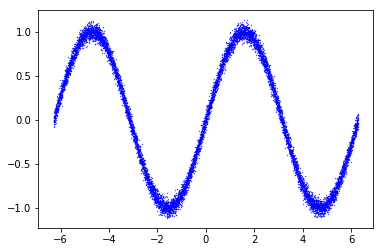

In [54]:
# Define the data
# The input data (features)
X = np.linspace(-2*np.pi, 2*np.pi, 10000)[:, None]
# The output data (labels)
y = np.sin(X) + 0.05 * np.random.normal(size=[len(X),1])

# Show the data
plt.scatter(X[:, 0], y[:, 0], s = 0.1, color ='b', marker='o')
plt.show()

Before creating the model, let's first write a function that shuffles each training batch. For every epoch we will shuffle the indices for each batch size.


In [55]:
def shuffle_batch(X, y, batch_size):
    # Shuffle the indices for each batch size
    rnd_idx = np.random.randint(low = 0, high = len(X), 
                            size = batch_size)
    # Get shuffled input 
    X_batch = X[rnd_idx]
    # Get shuffled output 
    y_batch = y[rnd_idx]
    return X_batch, y_batch

In [56]:
# Reset the graph
reset_graph()

# Let's create our model 
def create_simple_model():
    # Create variables for the model
    X_model = tf.placeholder(dtype = tf.float32, shape=[None, 1])
    y_model = tf.placeholder(dtype = tf.float32, shape=[None, 1])

    # Create weight variables 
    w0 = tf.get_variable(name='w0', shape=[1, 20], initializer = tf.glorot_uniform_initializer())
    w1 = tf.get_variable(name='w1', shape=[20, 20], initializer = tf.glorot_uniform_initializer())
    w2 = tf.get_variable(name='w2', shape=[20, 1], initializer = tf.glorot_uniform_initializer())
    
    # Create the bias variables 
    b0 = tf.get_variable(name='b0', shape=[20], initializer = tf.constant_initializer(0.))
    b1 = tf.get_variable(name='b1', shape=[20], initializer = tf.constant_initializer(0.))
    b2 = tf.get_variable(name='b2', shape=[1], initializer = tf.constant_initializer(0.))

    weights = [w0, w1, w2]
    biases = [b0, b1, b2]
    # The last layer does not have activations
    activations = [tf.nn.relu, tf.nn.relu, None]
    
    # Create the computation graph
    layer = X_model 
    # This zip will return a tuple (weights[i], biases[i], activations[i])
    for W, b, activation in zip(weights, biases, activations):
        # This is before activation
        # layer = input * weights + bias
        layer = tf.matmul(layer, W) + b
        if activation is not None:
            layer = activation(layer)
    # The prediction
    y_pred = layer
    
    return X_model, y_model, y_pred

In [57]:
# Create the simple model 
X_model, y_model, y_pred = create_simple_model()

In [58]:
# Define the loss
error = y_pred - y_model
mse = tf.reduce_mean(tf.square(error), name="mse")

In [59]:
# Define the optimizer
optimizer = tf.train.AdamOptimizer()

In [60]:
# Define the training operation
training_op = optimizer.minimize(mse)

In [61]:
# Initialize the variables
init = tf.global_variables_initializer()

In [62]:
# Let's create a saver to save the model variables 
saver = tf.train.Saver()

All the graph components and training ops have been defined. Let's now train our model.

In [63]:
# Number of epochs or iterations through whole thing
n_epochs = 10000

# Define the batch size
batch_size = 20

# Create the session 
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(init)
    
    # For each epoch get a new random subset of data
    for epoch in range(n_epochs):
        X_batch, y_batch = shuffle_batch(X, y, batch_size) 

        # Run the optimizer and training operation
        _, mse_run = sess.run([training_op, mse], feed_dict = {X_model: X_batch, y_model: y_batch})
        
        # Print out MSE every 1000 epochs
        if epoch % 1000 == 0:
            print('Epoch =', epoch, 'MSE =', mse_run)
            
            # Save the variables in a .ckpt file in tmp folder for each epoch
            save_path = saver.save(sess, "./temp/simple_model.ckpt")

    # Save the variables in a .ckpt file in tmp folder for last epoch
    save_path = saver.save(sess, "./temp/simple_model_final.ckpt")


Epoch = 0 MSE = 1.127466
Epoch = 1000 MSE = 0.07109076
Epoch = 2000 MSE = 0.030287012
Epoch = 3000 MSE = 0.05026132
Epoch = 4000 MSE = 0.015590106
Epoch = 5000 MSE = 0.005798582
Epoch = 6000 MSE = 0.0015964557
Epoch = 7000 MSE = 0.0038727012
Epoch = 8000 MSE = 0.0041067265
Epoch = 9000 MSE = 0.004539114


The neural network is now trained. Let's use it to make predictions. 

INFO:tensorflow:Restoring parameters from ./temp/simple_model.ckpt


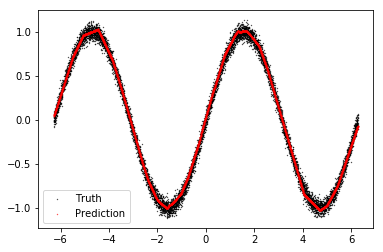

In [64]:
# Let's reset the graph
reset_graph()

# Create the model
X_model, y_model, y_pred = create_simple_model()

# Use the restore method since we saved instead of init 
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, "./temp/simple_model.ckpt")
    
    # Run the prediction
    y_pred_run = sess.run(y_pred, feed_dict={X_model: X})
    
    # Plot prediction over truth
    plt.scatter(X[:, 0], y[:, 0], c ='k', s = 0.1, label='Truth')
    plt.scatter(X[:, 0], y_pred_run[:, 0], c ='r', s = 0.1, label='Prediction')
    plt.legend(loc='lower left', fontsize=10)
    plt.show()

### Saving and Restoring Models

Let's talk about saving and restoring models. We have already seen in the example above how to save a model and restore it's variables using the `tf.train.Saver()`.

We can have a saver that loads and restores a variables under a different name using a dictionary.

In [ ]:
saver = tf.train.Saver({"weight_0": w_0})

We can also save the graph stucture itself by using the .meta file. Note the graph structure is saved as a .meta file.

One we load the .meta file, the graph structure is loaded and will return a saver that can be used to restore the graph state or the value of the variables as well.

In [67]:
# Let's start with an empty graph
reset_graph()

# This loads .meta file with the graph structure 
saver = tf.train.import_meta_graph("./temp/simple_model.ckpt.meta")

w1 = tf.get_default_graph().get_tensor_by_name("w1:0")

with tf.Session() as sess:
    # This will restore the graph's state
    saver.restore(sess, "./temp/simple_model.ckpt")

INFO:tensorflow:Restoring parameters from ./temp/simple_model.ckpt


Since we can load the graph structure then we cam import a pretrained model without having to have the corresponding Python code to build the graph. This is handy if you want to keep tweaking and saving you model. You can load a previosuly saved model without having to search for the version of the code that built it. 

### Visualizing the graph 

Inside Jupyter: To visualize the graph within Jupyter, we will use a TensorBoard server available online at https://tensorboard.appspot.com/ (so this will not work if you do not have Internet access). As far as I can tell, this code was originally written by Alex Mordvintsev in his DeepDream tutorial. Alternatively, you could use a tool like tfgraphviz.

In [68]:
from tensorflow_graph_in_jupyter import show_graph

In [69]:
# This will show the graph from simple_model above
show_graph(tf.get_default_graph())

In [71]:
from datetime import datetime

# Let's reset the graph
reset_graph()

# Include a timestamp in the log directory name so doesn't 
# merge the stats for each run
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = 'tf_logs'
logdir = "{}/run-{}".format(root_logdir, now)

Tensorboard is a graphical interface to visualize the training process for our model. Let's use Tensorboard to look at the simple model we created from before.  

In [72]:
# Create the simple model 
X_model, y_model, y_pred = create_simple_model()

# Define the loss
error = y_pred - y_model
mse = tf.reduce_mean(tf.square(error), name="mse")

# Define the optimizer
optimizer = tf.train.AdamOptimizer()

# Define the training operation
training_op = optimizer.minimize(mse)

# Initialize the variables
init = tf.global_variables_initializer()

# Below creates a node in graph that evals MSE value and 
# writes it to a TensorBoard compatible binary log string 
# called summary.
mse_summary = tf.summary.scalar('MSE', mse) 

# Creates a FileWriter that writes summaries to logfiles.
# The first parameter is the path of the log directory and  
# The second parameter is the graph you want to visualize
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [73]:
n_epochs = 10000
batch_size = 20

# Let's update the execution phase for TensorBoard
# Create the session 
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(init)
    
    # For each epoch get a new random subset of data
    for epoch in range(n_epochs):
        X_batch, y_batch = shuffle_batch(X, y, batch_size) 
        
        # Run the optimizer and training operation
        _, mse_run = sess.run([training_op, mse], feed_dict = {X_model: X_batch, y_model: y_batch})    
        
        # Print out MSE every 1000 epochs
        if epoch % 1000 == 0:
            print('Epoch =', epoch, 'MSE =', mse_run)
            # Record summaries
            summary_str = mse_summary.eval(feed_dict={X_model: X_batch, y_model: y_batch})
            file_writer.add_summary(summary_str, epoch)
        
        

Epoch = 0 MSE = 1.127466
Epoch = 1000 MSE = 0.07109076
Epoch = 2000 MSE = 0.030287012
Epoch = 3000 MSE = 0.05026132
Epoch = 4000 MSE = 0.015590106
Epoch = 5000 MSE = 0.005798582
Epoch = 6000 MSE = 0.0015964557
Epoch = 7000 MSE = 0.0038727012
Epoch = 8000 MSE = 0.0041067265
Epoch = 9000 MSE = 0.004539114


To run TensorBoard, use the following shell command

`tensorboard --logdir=path/to/log-directory`

where `logdir` points to the directory where the FileWriter serialized its data. If this `logdir` directory contains subdirectories which contain serialized data from separate runs, then TensorBoard will visualize the data from all of those runs. Once TensorBoard is running, navigate your web browser to `localhost:6006` to view the TensorBoard.

When looking at TensorBoard, you will see the navigation tabs in the top right corner. Each tab represents a set of serialized data that can be visualized.

In [74]:
# Close your Tensorboard session
file_writer.close()

### Tips and Tricks

##### (a) Check your dimensions

In [75]:
# "Surprising" resulting dimensions due to broadcasting
a = tf.constant(np.random.random((4, 1)))
b = tf.constant(np.random.random((1, 4)))
c = a * b
assert c.get_shape() == (4, 4)

##### (b) Check what variables have been created

In [76]:
reset_graph()
a = tf.get_variable('I_am_a_variable', shape=[4, 6])
b = tf.get_variable('I_am_a_variable_too', shape=[2, 7])
for var in tf.global_variables():
    print(var.name)

I_am_a_variable:0
I_am_a_variable_too:0


##### (c) Look at the [tensorflow API](https://www.tensorflow.org/api_docs/python/), or open up a python terminal and investigate!

In [77]:
help(tf.reduce_mean)

Help on function reduce_mean in module tensorflow.python.ops.math_ops:

reduce_mean(input_tensor, axis=None, keepdims=None, name=None, reduction_indices=None, keep_dims=None)
    Computes the mean of elements across dimensions of a tensor. (deprecated arguments)
    
    SOME ARGUMENTS ARE DEPRECATED. They will be removed in a future version.
    Instructions for updating:
    keep_dims is deprecated, use keepdims instead
    
    Reduces `input_tensor` along the dimensions given in `axis`.
    Unless `keepdims` is true, the rank of the tensor is reduced by 1 for each
    entry in `axis`. If `keepdims` is true, the reduced dimensions
    are retained with length 1.
    
    If `axis` is None, all dimensions are reduced, and a
    tensor with a single element is returned.
    
    For example:
    
    ```python
    x = tf.constant([[1., 1.], [2., 2.]])
    tf.reduce_mean(x)  # 1.5
    tf.reduce_mean(x, 0)  # [1.5, 1.5]
    tf.reduce_mean(x, 1)  # [1.,  2.]
    ```
    
    Args:
      

##### (d) Tensorflow has some built-in layers to simplify your code.

In [78]:
help(tf.layers.dense)

Help on function dense in module tensorflow.python.layers.core:

dense(inputs, units, activation=None, use_bias=True, kernel_initializer=None, bias_initializer=<tensorflow.python.ops.init_ops.Zeros object at 0x1166e9b70>, kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None, trainable=True, name=None, reuse=None)
    Functional interface for the densely-connected layer.
    
    This layer implements the operation:
    `outputs = activation(inputs.kernel + bias)`
    Where `activation` is the activation function passed as the `activation`
    argument (if not `None`), `kernel` is a weights matrix created by the layer,
    and `bias` is a bias vector created by the layer
    (only if `use_bias` is `True`).
    
    Arguments:
      inputs: Tensor input.
      units: Integer or Long, dimensionality of the output space.
      activation: Activation function (callable). Set it to None to maintain a
        linear activation

##### (e) Use [variable scope](https://www.tensorflow.org/guide/variables#sharing_variables) to keep your variables organized.

In [79]:
reset_graph()

# Create variables
with tf.variable_scope('layer_0'):
    w0 = tf.get_variable(name='w0', shape=[1, 20], initializer=tf.glorot_uniform_initializer())
    b0 = tf.get_variable(name='b0', shape=[20], initializer=tf.constant_initializer(0.))

with tf.variable_scope('layer_1'):
    w1 = tf.get_variable(name='w1', shape=[20, 20], initializer=tf.glorot_uniform_initializer())
    b1 = tf.get_variable(name='b1', shape=[20], initializer=tf.constant_initializer(0.))
    
with tf.variable_scope('layer_2'):
    w2 = tf.get_variable(name='w2', shape=[20, 1], initializer=tf.glorot_uniform_initializer())
    b2 = tf.get_variable(name='b2', shape=[1], initializer=tf.constant_initializer(0.))

# Print the variables
var_names = sorted([v.name for v in tf.global_variables()])
print('\n'.join(var_names))

layer_0/b0:0
layer_0/w0:0
layer_1/b1:0
layer_1/w1:0
layer_2/b2:0
layer_2/w2:0


##### (f) You can specify which GPU you want to use and how much memory you want to use

In [80]:
gpu_device = 0
gpu_frac = 0.5

# make only one of the GPUs visible
import os
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_device)

# only use part of the GPU memory
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_frac)
config = tf.ConfigProto(gpu_options=gpu_options)

# create the session
tf_sess = tf.Session(graph=tf.Graph(), config=config)

### References

1. https://www.tensorflow.org/guide/
2. Geron, Aurelion. *Hands On Machine Learning With Sci-Kit Learn and Tensorflow*. O'Reilly, 2016.
